# Notebook to plot noise correlation versus signal correlation of all units.

This notebook requires noise correlation data cached in
`../../../cache/figures/figure_5/noise_correlations_ring`. This can be
downloaded from the OSF repo or can be generated by running
`$ python run_compute_ring.py`.

This notebook plots noise correlation as a function of signal correlation for
all units and saves the resulting plot in the current directory.

In [1]:
"""Imports."""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load data."""

DATA_DIR = Path("../../../cache/figures/figure_5/noise_correlations_ring")

dfs = []
for subject_dir in DATA_DIR.iterdir():
    for session_dir in subject_dir.iterdir():
        results_path = session_dir / "noise_correlations.csv"
        df = pd.read_csv(results_path)
        df['subject'] = subject_dir.name
        df['session'] = session_dir.name
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df = df[
    (df["num_signal_trials"] >= 50)
    & (df["num_noise_trials"] >= 200)
]
print(df.columns)

Index(['unit_0', 'unit_1', 'signal_ccs', 'noise_ccs', 'num_signal_trials',
       'num_noise_trials', 'subject', 'session'],
      dtype='object')


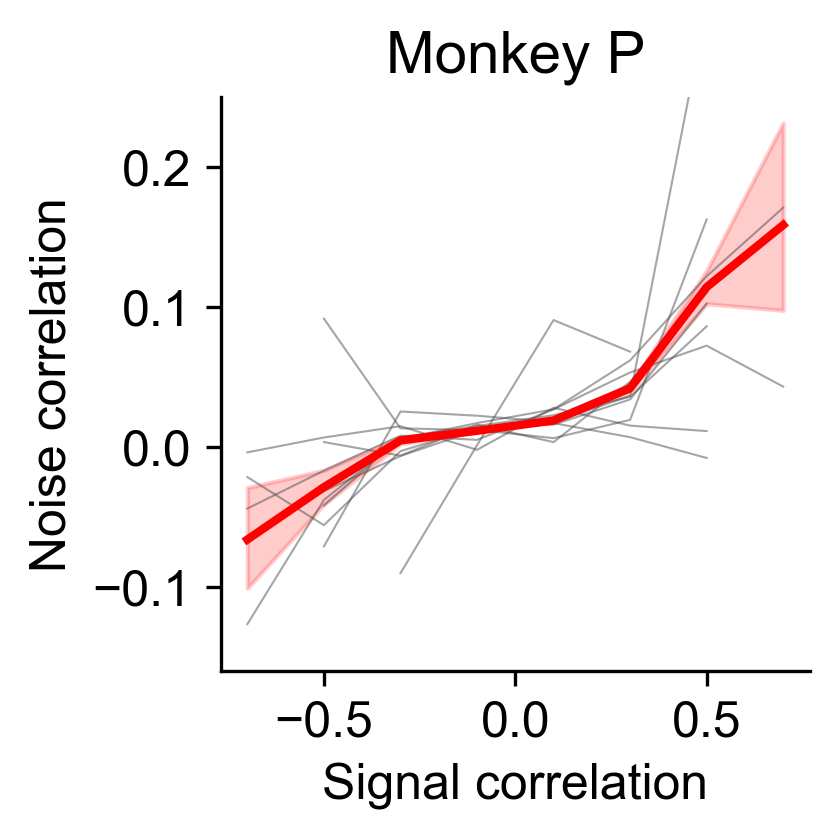

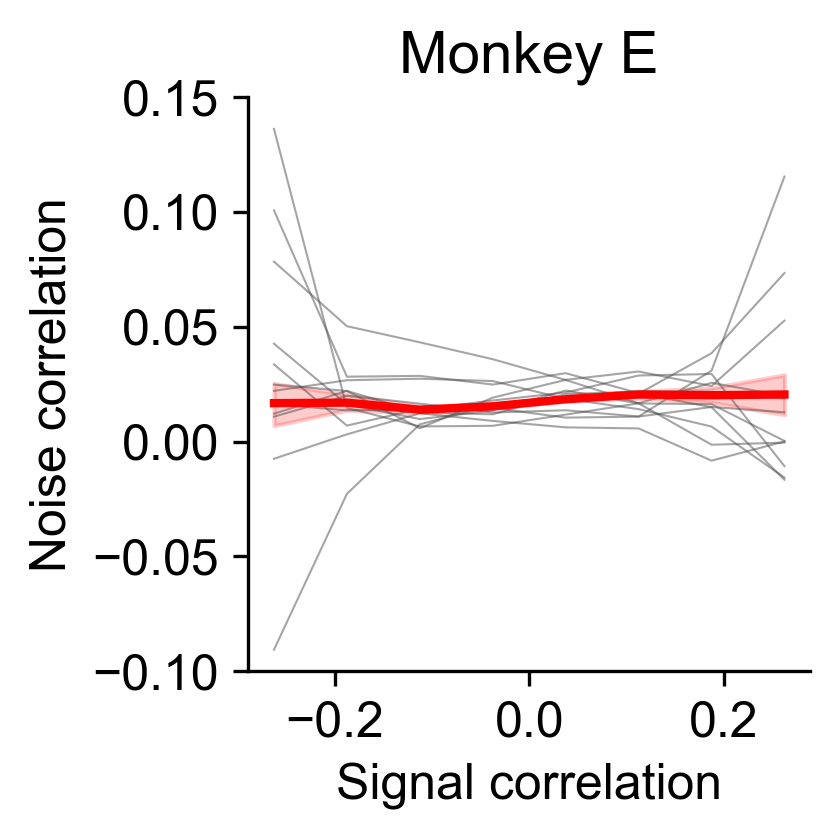

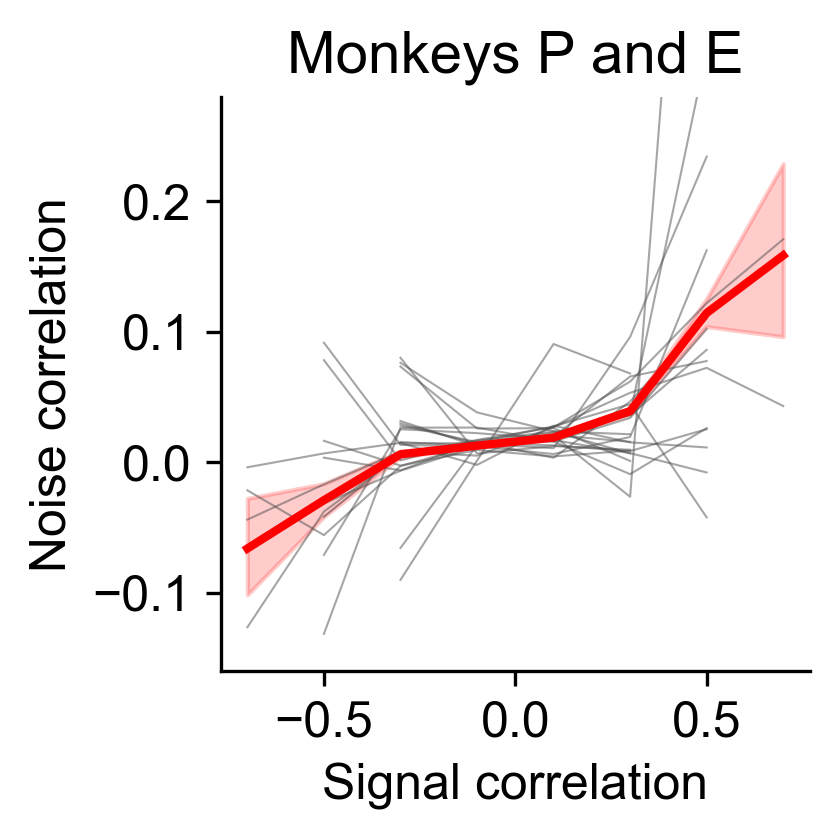

In [3]:
"""Make plot."""

SUBJECTS_SPANS = [
    (('Perle',), 0.8, (-0.16, 0.25)),
    (('Elgar',), 0.3, (-0.1, 0.15)),
    (('Perle', 'Elgar'), 0.8, (-0.16, 0.28)),
]
_NUM_BINS = 8

for subjects, span, ylim in SUBJECTS_SPANS:
    df_subjects = df[df["subject"].isin(subjects)].copy().reset_index(drop=True)
    
    # Make bins for signal correlation
    bin_edges = np.linspace(-span, span, _NUM_BINS + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_edges[0] = -np.inf
    bin_edges[-1] = np.inf
    df_subjects["signal_corr_bin"] = pd.cut(df_subjects["signal_ccs"], bin_edges, labels=bin_centers)


    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(2.9, 2.9))
    sns.despine(ax=ax)
    for session, df_session in df_subjects.groupby("session"):
        sns.lineplot(
            data=df_session,
            ax=ax,
            x="signal_corr_bin",
            y="noise_ccs",
            c=(0.3, 0.3, 0.3),
            alpha=0.5,
            errorbar=None,
            linewidth=0.5,
        )
    sns.lineplot(
        data=df_subjects,
        ax=ax,
        x="signal_corr_bin",
        y="noise_ccs",
        c='r',
        linewidth=2,
    )
    ax.set_xlabel("Signal correlation")
    ax.set_ylabel("Noise correlation")
    ax.set_ylim(ylim)
    
    # Make title
    if len(subjects) == 1:
        ax.set_title('Monkey ' + subjects[0][0])
    else:
        ax.set_title('Monkeys ' + ' and '.join([s[0] for s in subjects]))
    
    # Save figure
    fig.tight_layout()
    fig.savefig(f"./plots/noise_correlation_{'_'.join([s[0] for s in subjects])}.pdf", bbox_inches='tight', pad_inches=0.01)